In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense

import sklearn
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, normalize

import os
import re
import graphviz
from pprint import pprint

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv('../training.csv')
train_orig_df = train_df.copy()
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,...,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,...,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


#### Autoencoder Preprocessing

In [3]:
# Get rid of redundant columns
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_lead', 'participant1_order',
                  'participant2_is_lead', 'participant2_order',
                  'participant3_is_lead', 'participant3_order',
                  'participant4_is_lead', 'participant4_order',
                  'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in train_df.columns if i not in redundant_cols]

train_df = train_df[useful_cols]

In [4]:
all_cols = [col for col in train_df.columns]
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 28
Amount of categorical columns: 19


In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

print('Shape of encoded dataframe -> {}'.format(train_enc_df.shape))
train_enc_df.head()

Shape of encoded dataframe -> (9418, 88)


,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.99973,1,0,1.00000,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.99977,0,2,0.12336,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.99977,0,3,0.12336,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.99949,0,0,0.00000,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [6]:
# Normalization

x = train_enc_df.values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

norm_df = pd.DataFrame(x_scaled)
norm_df.index = train_enc_df.index
rename_to_new = {old: new for old, new in zip(list(range(norm_df.shape[1])), train_enc_df.columns)}
norm_df = norm_df.rename(rename_to_new, axis=1)

norm_df.head()

,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,...,participant4_focus_sales,participant5_action_commented,participant5_action_liked,participant5_action_viewed,participant5_gender_female,participant5_gender_male,participant5_focus_engineering,participant5_focus_marketing,participant5_focus_other,participant5_focus_sales
0,0.999789,0.015625,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.999833,0.000000,0.013793,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.999833,0.000000,0.020690,0.12336,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.999522,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [7]:
X_train, X_valid = train_test_split(norm_df, train_size=0.85, shuffle=True, random_state=1)

print('Shape of X_train = {}'.format(X_train.shape))
print('Shape of X_valid = {}'.format(X_valid.shape))

Shape of X_train = (8005, 88)
Shape of X_valid = (1413, 88)


#### Building Autoencoder

##### Deep Autoencoder

In [8]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(32, activation='linear', name='bottleneck'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Epoch 1/100
32/32 [==============================] - 1s 33ms/step - loss: 0.1632 - val_loss: 0.1017
Epoch 2/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0862 - val_loss: 0.0715
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0643 - val_loss: 0.0566
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0524 - val_loss: 0.0469
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0427 - val_loss: 0.0379
Epoch 6/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0354 - val_loss: 0.0319
Epoch 7/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0301 - val_loss: 0.0279
Epoch 8/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0268 - val_loss: 0.0259
Epoch 9/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0246 - val_loss: 0.0236
Epoch 10/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0226 - val_loss: 0.0219

32/32 [==============================] - 1s 16ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 83/100
32/32 [==============================] - ETA: 0s - loss: 0.004 - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 84/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 85/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 86/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 87/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 88/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 89/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 90/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 91/100
32/32 [==============================] - 1s 19ms/step - loss: 0.004

In [9]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 32

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Sparse Autoencoder

In [10]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(35, activation='linear', name='bottleneck', activity_regularizer=keras.regularizers.l1(1e-5)))  # adding regularizer
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Epoch 1/100
32/32 [==============================] - 1s 25ms/step - loss: 0.1717 - val_loss: 0.1122
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0942 - val_loss: 0.0755
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0661 - val_loss: 0.0571
Epoch 4/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0529 - val_loss: 0.0478
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0445 - val_loss: 0.0409
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0381 - val_loss: 0.0356
Epoch 7/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0335 - val_loss: 0.0314
Epoch 8/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0302 - val_loss: 0.0286
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0272 - val_loss: 0.0258
Epoch 10/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0245 - val_loss: 0.0233

32/32 [==============================] - 1s 24ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 83/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 84/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 85/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 86/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 87/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 88/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 89/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 90/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 91/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0048
Epo

In [11]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 35

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Denoising Autoencoder

In [12]:
# Creating noise data
noise_factor = 0.3
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) - noise_factor / 2
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) - noise_factor / 2
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)

In [13]:
autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(35, activation='linear', name='bottleneck'))  # adding regularizer
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_noisy, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid_noisy, X_valid))

Epoch 1/100
32/32 [==============================] - 1s 25ms/step - loss: 0.1777 - val_loss: 0.1214
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.1039 - val_loss: 0.0879
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0775 - val_loss: 0.0665
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0618 - val_loss: 0.0559
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0532 - val_loss: 0.0499
Epoch 6/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0474 - val_loss: 0.0449
Epoch 7/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0432 - val_loss: 0.0414
Epoch 8/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0397 - val_loss: 0.0387
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0368 - val_loss: 0.0360
Epoch 10/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0346 - val_loss: 0.0337

32/32 [==============================] - 1s 18ms/step - loss: 0.0124 - val_loss: 0.0157
Epoch 83/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0124 - val_loss: 0.0158
Epoch 84/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0123 - val_loss: 0.0159
Epoch 85/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0124 - val_loss: 0.0156
Epoch 86/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0121 - val_loss: 0.0156
Epoch 87/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0122 - val_loss: 0.0158
Epoch 88/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0121 - val_loss: 0.0153
Epoch 89/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0120 - val_loss: 0.0154
Epoch 90/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0119 - val_loss: 0.0154
Epoch 91/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0118 - val_loss: 0.0153
Epo

In [14]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 35

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

##### Contractive Autoencoder

In [15]:
def contractive_loss(y_pred, y_true, lam=1e-4):
    import tensorflow.keras.backend as K
    
    mse = K.mean(K.square(y_true - y_pred), axis=1)

    W = K.variable(value=autoencoder.get_layer('bottleneck').get_weights()[0])  # N x N_hidden
    W = K.transpose(W)  # N_hidden x N
    h = autoencoder.get_layer('bottleneck').output
    dh = h * (1 - h)  # N_batch x N_hidden

    # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

    return mse + contractive

In [16]:
tf.compat.v1.disable_eager_execution()

autoencoder = Sequential()
autoencoder.add(Dense(128, activation='relu', input_shape=(88,)))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(30, activation='linear', name='bottleneck'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(88, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss=contractive_loss, metrics=['mse'])

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 8005 samples, validate on 1413 samples
Epoch 1/100
8005/8005 [==============================] - 1s 86us/sample - loss: 0.1826 - mse: 0.1789 - val_loss: 0.1275 - val_mse: 0.1259
Epoch 2/100
8005/8005 [==============================] - 0s 61us/sample - loss: 0.1060 - mse: 0.1037 - val_loss: 0.0864 - val_mse: 0.0841
Epoch 3/100
8005/8005 [==============================] - 1s 66us/sample - loss: 0.0770 - mse: 0.0749 - val_loss: 0.0664 - val_mse: 0.0643
Epoch 4/100
8005/8005 [==============================] - 1s 70us/sample - loss: 0.0606 - mse: 0.0586 - val_loss: 0.0537 - val_mse: 0.0518
Epoch 5/100
8005/8005 [==============================] - 1s 75us/sample - loss: 0.0499 - mse: 0.0482 - val_loss: 0.0454 - val_mse: 0.0438
Epoch 6/100
8005/8005 [==============================] - 1s 69us/sample - loss: 0.0424 - mse: 0.0408 - val_loss: 0.0389 - val_mse: 0.0374
Epoch 7/100
8005/8005 [====================

Epoch 57/100
8005/8005 [==============================] - 0s 60us/sample - loss: 0.0038 - mse: 0.0033 - val_loss: 0.0046 - val_mse: 0.0041
Epoch 58/100
8005/8005 [==============================] - 0s 57us/sample - loss: 0.0037 - mse: 0.0032 - val_loss: 0.0045 - val_mse: 0.0041
Epoch 59/100
8005/8005 [==============================] - 1s 79us/sample - loss: 0.0035 - mse: 0.0031 - val_loss: 0.0043 - val_mse: 0.0039
Epoch 60/100
8005/8005 [==============================] - 0s 53us/sample - loss: 0.0035 - mse: 0.0030 - val_loss: 0.0043 - val_mse: 0.0039
Epoch 61/100
8005/8005 [==============================] - 0s 50us/sample - loss: 0.0034 - mse: 0.0029 - val_loss: 0.0043 - val_mse: 0.0039
Epoch 62/100
8005/8005 [==============================] - 1s 65us/sample - loss: 0.0033 - mse: 0.0028 - val_loss: 0.0043 - val_mse: 0.0038
Epoch 63/100
8005/8005 [==============================] - 0s 58us/sample - loss: 0.0032 - mse: 0.0028 - val_loss: 0.0041 - val_mse: 0.0037
Epoch 64/100
8005/8005 [===

In [17]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(X_train)  # bottleneck representation
decoded_output = autoencoder.predict(X_train)        # reconstruction
encoding_dim = 30

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

#### Clustering Preprocessing

In [18]:
encoded_train_df = pd.DataFrame(encoder.predict(norm_df))
print("Dataframe from latent vectors of processed dataset has shape = {}.".format(encoded_train_df.shape))
encoded_train_df.head()

Dataframe from latent vectors of processed dataset has shape = (9418, 30).


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.892096,0.136498,0.069984,0.322345,-0.059621,0.301884,0.547718,0.326100,0.760968,0.299455,...,0.096474,0.476995,-0.171732,0.453968,0.063374,0.866504,0.779914,0.884011,0.036854,0.082265
1,0.063319,0.663336,0.592229,0.844698,0.137396,0.741718,1.141259,0.728198,-0.090076,0.247712,...,1.080451,0.552184,-0.151359,0.517802,0.813208,0.243151,0.546053,0.548684,0.366419,0.057909
2,-0.070753,0.520376,0.459167,0.448289,0.160961,0.161224,0.950220,0.901341,0.061027,0.401288,...,1.171681,0.900454,0.567002,0.520653,0.400829,1.168728,0.624139,0.774174,0.470684,0.554707
3,0.842344,-0.111245,0.245225,-0.069895,0.046265,0.155472,0.583423,0.200319,-0.071969,0.231160,...,1.040567,0.147928,-0.079035,0.864464,0.047825,0.241428,0.976040,0.747861,0.012755,0.706506
4,0.842344,-0.111245,0.245225,-0.069895,0.046265,0.155472,0.583423,0.200319,-0.071969,0.231160,...,1.040567,0.147928,-0.079035,0.864464,0.047825,0.241428,0.976040,0.747861,0.012755,0.706506


In [19]:
# Need this for "normalized" clustering with cosine distance
# (normalization in sklearn equals to using cosine distance using K-Means clustering)
normalized_vectors = normalize(encoded_train_df)
print(normalized_vectors.shape)

(9418, 30)


#### Clustering

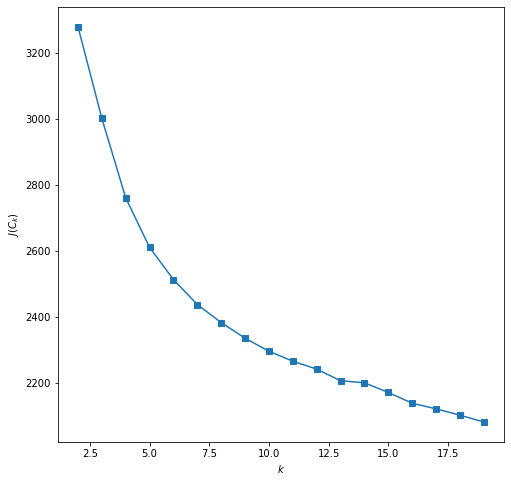

In [20]:
# Normalized K-Means (with cosine distance)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(18)]

plt.figure(figsize=(8, 8))
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.plot(range(2, 20), scores, marker='s')
plt.show()

We will take K = 6 as a possible elbow point.

In [21]:
# Creating models for K-Means clustering with K = [3, 10].
norm_kmeans3 = KMeans(n_clusters=3, random_state=1).fit(normalized_vectors)
norm_kmeans4 = KMeans(n_clusters=4, random_state=1).fit(normalized_vectors)
norm_kmeans5 = KMeans(n_clusters=5, random_state=1).fit(normalized_vectors)
norm_kmeans6 = KMeans(n_clusters=6, random_state=1).fit(normalized_vectors)
norm_kmeans7 = KMeans(n_clusters=7, random_state=1).fit(normalized_vectors)
norm_kmeans8 = KMeans(n_clusters=8, random_state=1).fit(normalized_vectors)
norm_kmeans9 = KMeans(n_clusters=9, random_state=1).fit(normalized_vectors)
norm_kmeans10 = KMeans(n_clusters=10, random_state=1).fit(normalized_vectors)

#### Visualization

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [23]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components, random_state=1).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    colors = plt.get_cmap('tab10').colors
    colors = plt.get_cmap('Set3').colors
    N = 360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for label in tsne_3d_df[label_column].unique():
        label_df = tsne_3d_df[tsne_3d_df[label_column] == label]
        sc = ax.scatter(label_df['x'], label_df['y'], label_df['z'], c=colors[label],
               label=f"Cluster {label}", s=6, depthshade=True)
  
    ax.legend(loc='upper right')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('kmeans_results/{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [24]:
final_df = encoded_train_df.copy()
final_df['rank'] = train_orig_df['rank']

In [25]:
tsne_3d_df = prepare_tsne(3, final_df, norm_kmeans3.labels_)
tsne_3d_df['normalized_kmeans4'] = norm_kmeans4.labels_
tsne_3d_df['normalized_kmeans5'] = norm_kmeans5.labels_
tsne_3d_df['normalized_kmeans6'] = norm_kmeans6.labels_
tsne_3d_df['normalized_kmeans7'] = norm_kmeans7.labels_
tsne_3d_df['normalized_kmeans8'] = norm_kmeans8.labels_
tsne_3d_df['normalized_kmeans9'] = norm_kmeans9.labels_
tsne_3d_df['normalized_kmeans10'] = norm_kmeans10.labels_

tsne_3d_df.head()

,x,y,z,labels,normalized_kmeans4,normalized_kmeans5,normalized_kmeans6,normalized_kmeans7,normalized_kmeans8,normalized_kmeans9,normalized_kmeans10
0,-10.295351,-3.313507,17.763220,0,1,3,5,5,3,5,5
1,-15.034721,-14.101745,-9.652936,0,1,2,3,3,5,0,0
2,-16.689869,2.145481,-12.881071,2,0,0,1,6,6,7,7
3,-8.313754,32.578850,-12.486033,1,2,1,0,0,2,2,2
4,-7.364239,31.993700,-12.874967,1,2,1,0,0,2,2,2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


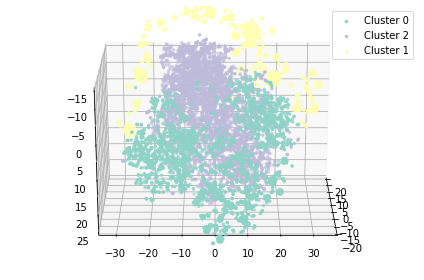

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

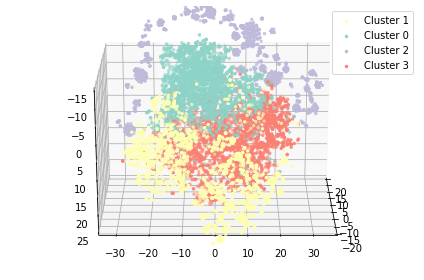

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

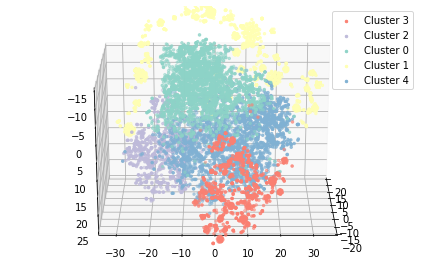

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

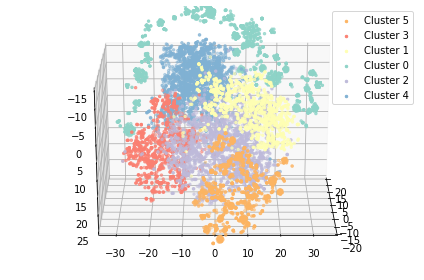

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

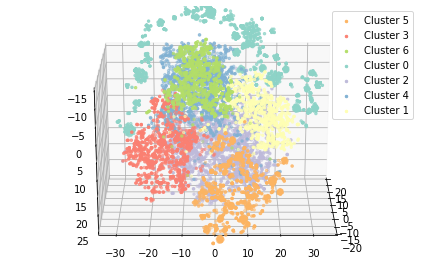

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

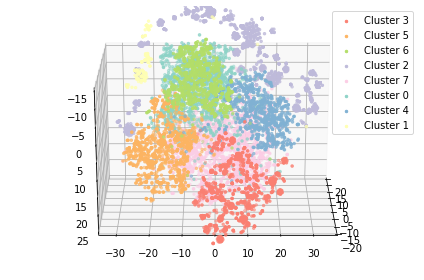

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

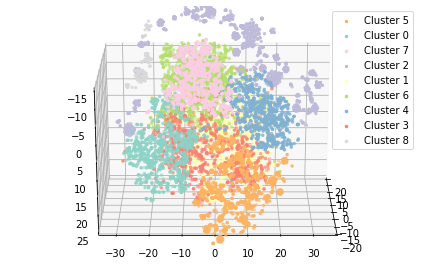

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

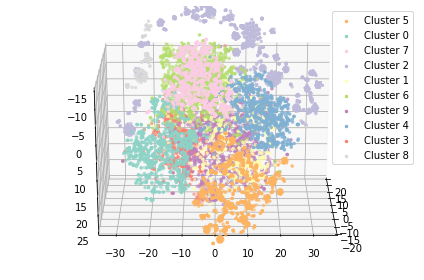

In [26]:
plot_animation(tsne_3d_df, 'labels', 'best_normalized_kmeans3')
plot_animation(tsne_3d_df, 'normalized_kmeans4', 'best_normalized_kmeans4')
plot_animation(tsne_3d_df, 'normalized_kmeans5', 'best_normalized_kmeans5')
plot_animation(tsne_3d_df, 'normalized_kmeans6', 'best_normalized_kmeans6')
plot_animation(tsne_3d_df, 'normalized_kmeans7', 'best_normalized_kmeans7')
plot_animation(tsne_3d_df, 'normalized_kmeans8', 'best_normalized_kmeans8')
plot_animation(tsne_3d_df, 'normalized_kmeans9', 'best_normalized_kmeans9')
plot_animation(tsne_3d_df, 'normalized_kmeans10', 'best_normalized_kmeans10')

### Interpretation

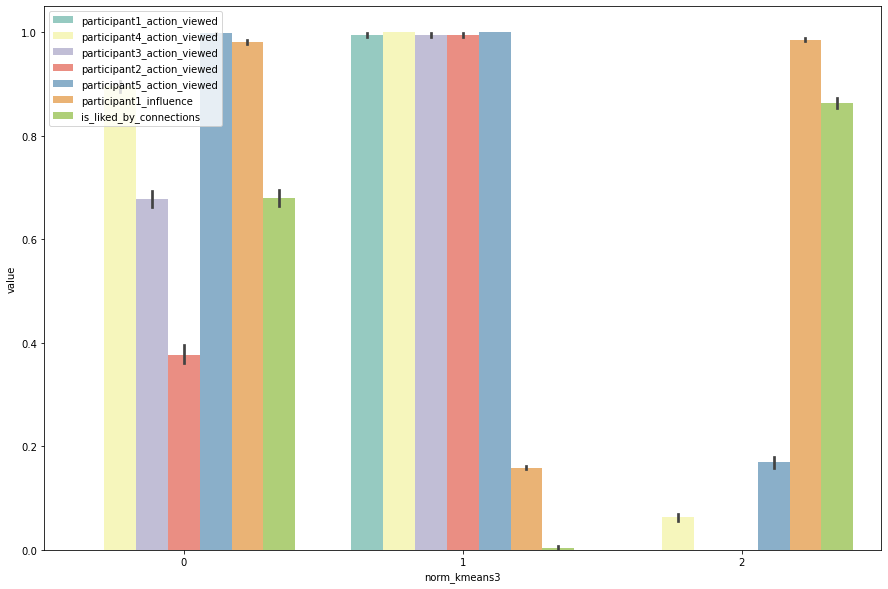

In [27]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans3'] = norm_kmeans3.labels_

df_mean = scaled_df.groupby('norm_kmeans3').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans3']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans3')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans3', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans3_results.jpg", dpi=300)

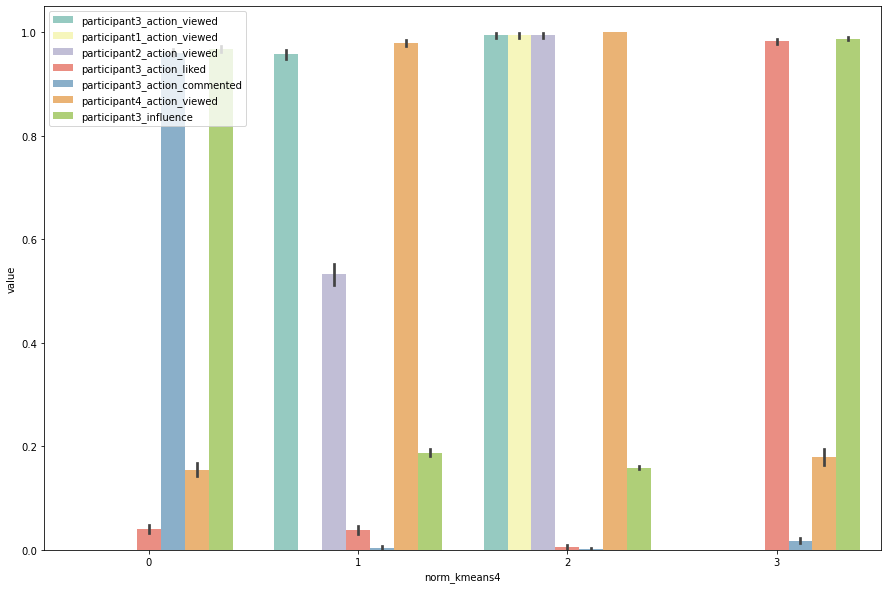

In [28]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans4'] = norm_kmeans4.labels_

df_mean = scaled_df.groupby('norm_kmeans4').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans4']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans4')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans4', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans4_results.jpg", dpi=300)

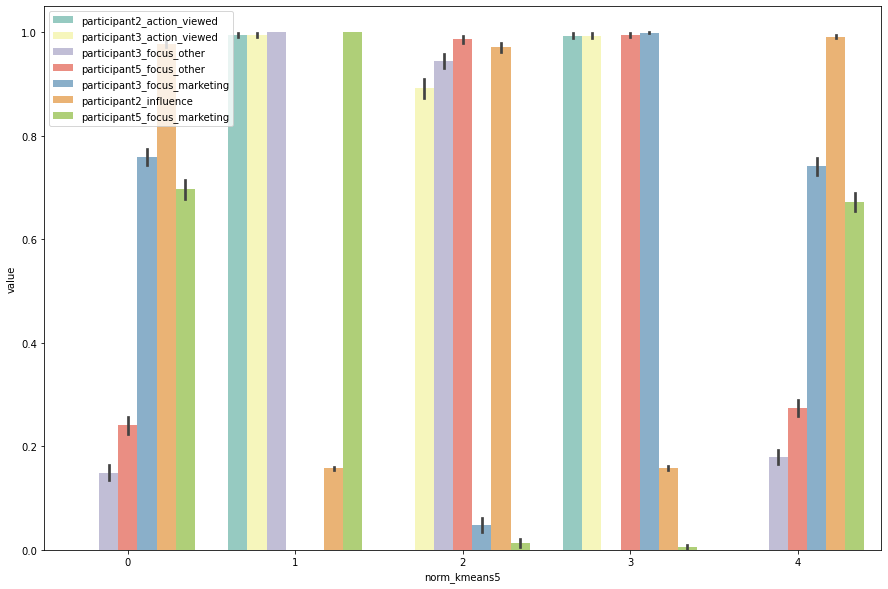

In [29]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans5'] = norm_kmeans5.labels_

df_mean = scaled_df.groupby('norm_kmeans5').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans5']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans5')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans5', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans5_results.jpg", dpi=300)

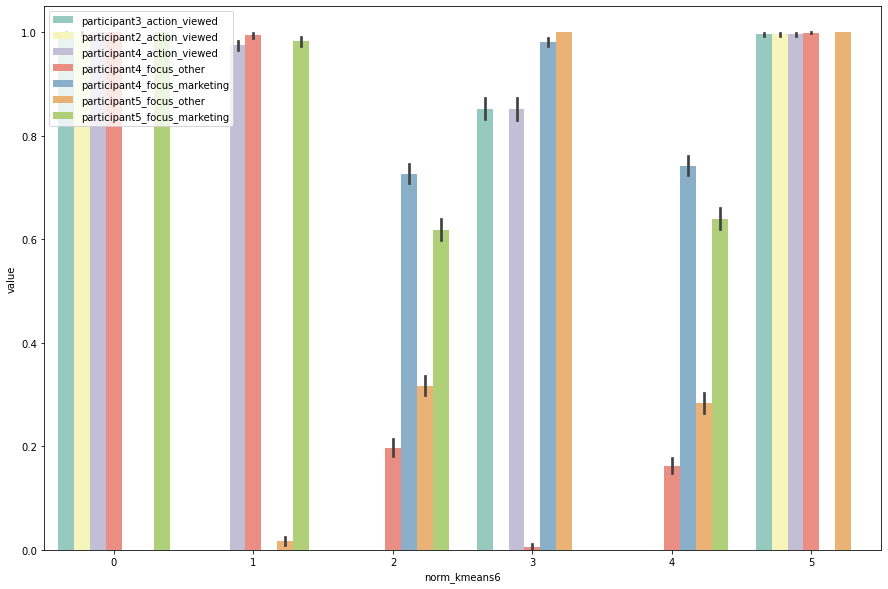

In [30]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans6'] = norm_kmeans6.labels_

df_mean = scaled_df.groupby('norm_kmeans6').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans6']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans6')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans6', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans6_results.jpg", dpi=300)

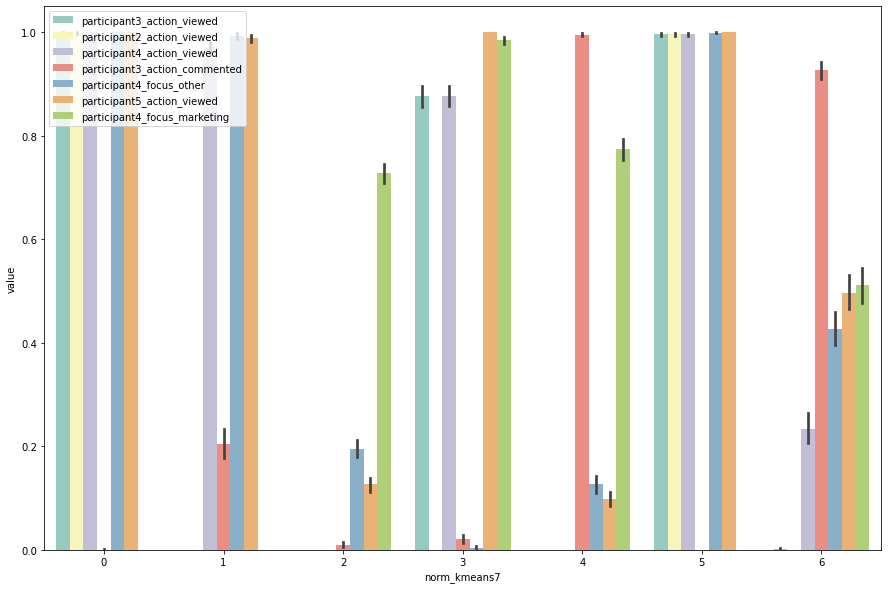

In [31]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans7'] = norm_kmeans7.labels_

df_mean = scaled_df.groupby('norm_kmeans7').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans7']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans7')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans7', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans7_results.jpg", dpi=300)

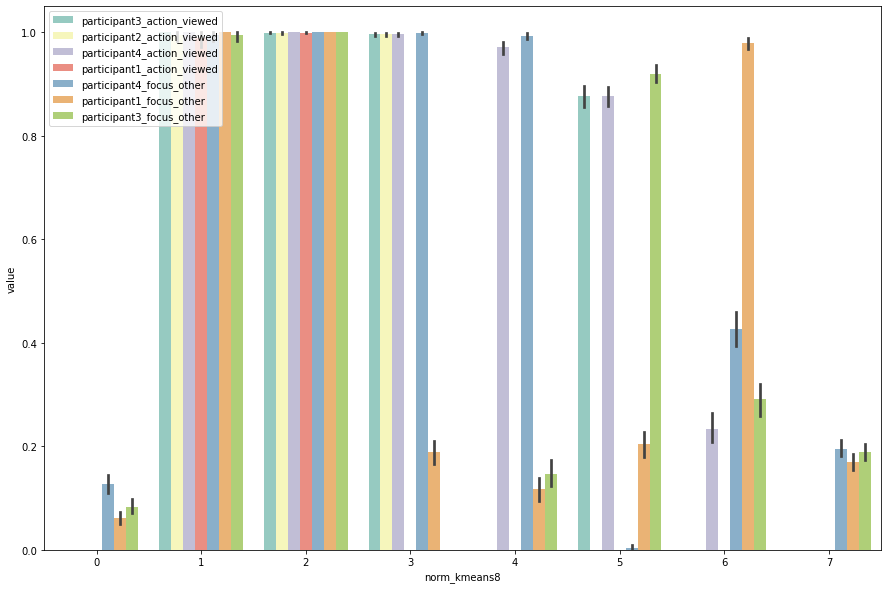

In [32]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans8'] = norm_kmeans8.labels_

df_mean = scaled_df.groupby('norm_kmeans8').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans8']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans8')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans8', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans8_results.jpg", dpi=300)

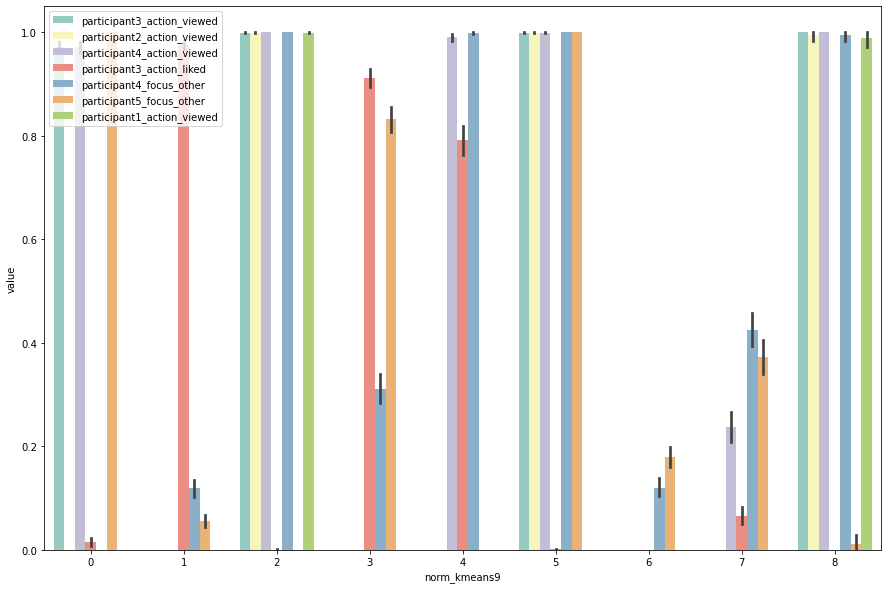

In [33]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans9'] = norm_kmeans9.labels_

df_mean = scaled_df.groupby('norm_kmeans9').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['norm_kmeans9']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans9')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans9', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans9_results.jpg", dpi=300)

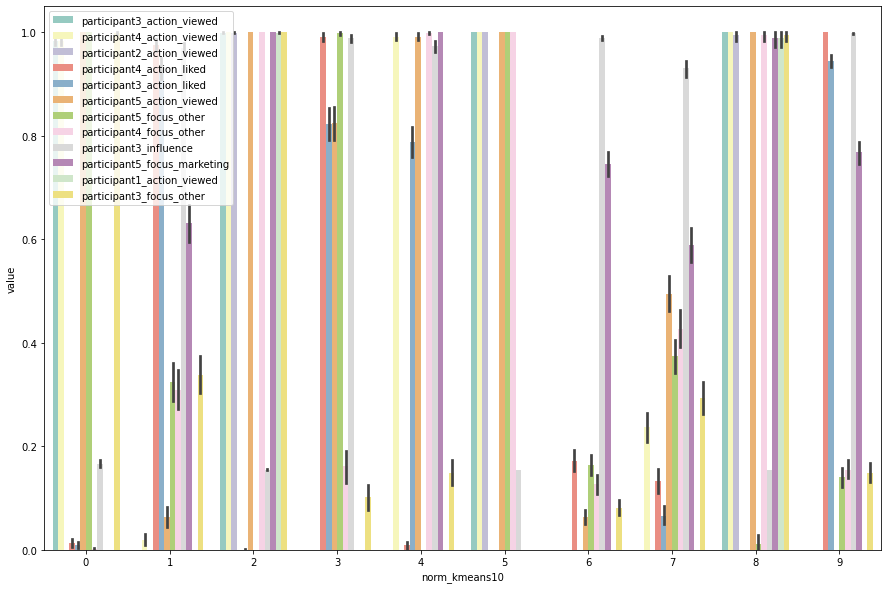

In [34]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(train_enc_df))
scaled_df.columns = train_enc_df.columns
scaled_df['norm_kmeans10'] = norm_kmeans10.labels_

df_mean = scaled_df.groupby('norm_kmeans10').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(12)['var'].values) + ['norm_kmeans10']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='norm_kmeans10')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='norm_kmeans10', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmeans_results/best_norm_kmeans10_results.jpg", dpi=300)

#### Graph Interpretation

In [35]:
def reduce_graphviz(graph_data):
    graph_data = re.sub(r"gini = [-+]?([0-9]*\.[0-9]+|[0-9]+)\\n", "", graph_data)
    graph_data = re.sub(r"samples = [-+]?([0-9]*\.[0-9]+|[0-9]+)\\n", "", graph_data)
    return graph_data

In [36]:
tree3 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans3.labels_)
graph_data = tree.export_graphviz(tree3, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans3_graph', format='png')

'kmeans_results/best_kmeans3_graph.png'

In [37]:
tree4 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans4.labels_)
graph_data = tree.export_graphviz(tree4, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans4_graph', format='png')

'kmeans_results/best_kmeans4_graph.png'

In [38]:
tree5 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans5.labels_)
graph_data = tree.export_graphviz(tree5, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3', '4'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans5_graph', format='png')

'kmeans_results/best_kmeans5_graph.png'

In [39]:
tree6 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans6.labels_)
graph_data = tree.export_graphviz(tree6, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3', '4', '5'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans6_graph', format='png')

'kmeans_results/best_kmeans6_graph.png'

In [40]:
tree7 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans7.labels_)
graph_data = tree.export_graphviz(tree7, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3', '4', '5', '6'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans7_graph', format='png')

'kmeans_results/best_kmeans7_graph.png'

In [41]:
tree8 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans8.labels_)
graph_data = tree.export_graphviz(tree8, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3', '4', '5', '6', '7'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans8_graph', format='png')

'kmeans_results/best_kmeans8_graph.png'

In [42]:
tree9 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans9.labels_)
graph_data = tree.export_graphviz(tree9, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans9_graph', format='png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.891449 to fit


'kmeans_results/best_kmeans9_graph.png'

In [43]:
tree10 = DecisionTreeClassifier(random_state=1).fit(X=train_enc_df, y=norm_kmeans10.labels_)
graph_data = tree.export_graphviz(tree10, out_file=None, feature_names=train_enc_df.columns, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], filled=True)
graph_data = reduce_graphviz(graph_data)
graph = graphviz.Source(graph_data)
graph.render('kmeans_results/best_kmeans10_graph', format='png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.811245 to fit


'kmeans_results/best_kmeans10_graph.png'